# Notebook for Modeling Beat Sequences with LSTM Model

This notebook loads LSTM-ready sequences (generated in 01b_Data_Preparation notebook), trains a simple LSTM model on normal sequences only, and evaluates reconstruction errors for anomaly detection. 

## Setup

In [10]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import subprocess
import json
import sys
sys.path.append("../")

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
from scripts.utils import get_project_path
from scripts.plotting import plot_recon_error_dist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train LSTM Autoencoder vis CLI

In [2]:
model_dir = get_project_path("models", "lstm")
os.makedirs(model_dir, exist_ok=True)

train_script = get_project_path("scripts", "train_lstm_autoencoder.py")
x_path = get_project_path("data", "processed", "LSTM_X_sequences.npy")
y_path = get_project_path("data", "processed", "LSTM_y_labels.npy")

subprocess.run([
    "python", train_script,
    "--x-path", x_path,
    "--y-path", y_path,
    "--output-dir", model_dir
])

CompletedProcess(args=['python', 'C:\\Users\\vscerra\\Desktop\\DataScienceProjects\\mitbih_arrhythmia_project\\scripts\\train_lstm_autoencoder.py', '--x-path', 'C:\\Users\\vscerra\\Desktop\\DataScienceProjects\\mitbih_arrhythmia_project\\data\\processed\\LSTM_X_sequences.npy', '--y-path', 'C:\\Users\\vscerra\\Desktop\\DataScienceProjects\\mitbih_arrhythmia_project\\data\\processed\\LSTM_y_labels.npy', '--output-dir', 'C:\\Users\\vscerra\\Desktop\\DataScienceProjects\\mitbih_arrhythmia_project\\models\\lstm'], returncode=0)

## Load Data

In [3]:
X = np.load(x_path)
y = np.load(y_path)

## Load Model

In [4]:
from tensorflow.keras.models import load_model

model = load_model(os.path.join(model_dir, "lstm_autoencoder.h5"))

## Evaluate on All Data

In [5]:
timesteps, input_dim = X.shape[1], X.shape[2]
y_true = y != "N" # abnormal = 1

X_pred = model.predict(X)
recon_error = np.mean((X_pred - X)**2, axis = (1,2))

5/5 [==============================] - 3s 8ms/step


## Metrics

In [6]:
roc_auc = roc_auc_score(y_true, recon_error)
prec, recall, thresholds = precision_recall_curve(y_true, recon_error)
pr_auc = auc(recall, prec)
f1_scores = [f1_score(y_true, recon_error >= t) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

In [7]:
print(f"ROC AUC: {roc_auc: .3f}")
print(f"PR AUC: {pr_auc: .3f}")
print(f"Best Threshold: {best_thresh: .5f}")
print(f"Best F1 Score: {best_f1: .3f}")

ROC AUC:  0.604
PR AUC:  0.142
Best Threshold:  0.20757
Best F1 Score:  0.348


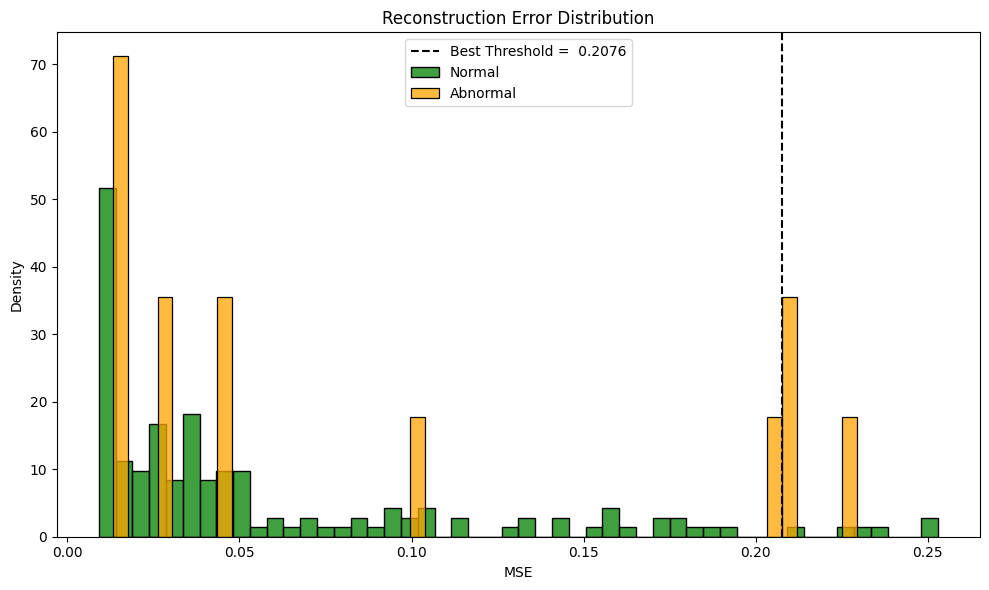

In [8]:
plot_recon_error_dist(recon_error, y_true, best_thresh)

## Save Metrics for Dashboard Comparison Notebook

In [11]:
output_dir = model_dir

np.save(os.path.join(output_dir, "y_true.npy"), y_true)
np.save(os.path.join(output_dir, "recon_error.npy"), recon_error)

# Save Metrics
metrics = {
    "roc_auc": float(roc_auc),
    "pr_auc": float(pr_auc),
    "best_f1": float(best_f1),
    "best_thresh": float(best_thresh)
}

with open(os.path.join(output_dir, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent = 2)

print(f"Saved evaluation outputs to: {output_dir}")


Saved evaluation outputs to: C:\Users\vscerra\Desktop\DataScienceProjects\mitbih_arrhythmia_project\models\lstm
